# Regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Generating data points

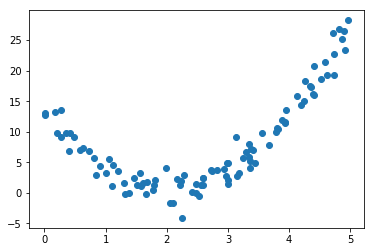

In [3]:
X=np.random.rand(100)*5
noise=np.random.randn(100)*1.5
t=3*(X-2)**2+1+noise
plt.scatter(X,t);

## Linear Basic Function Model

In [4]:
class LinearBasisFunctionModel:
    def __init__(self,M,s,mu):
        self.M=M   #number of basis functions
        self.s=s   #standard deviation of basis functions
        self.mu=mu #average of basis functions
    def gauss(self,x,mu):
        return np.exp(-((x-mu)**2)/(2*self.s**2))
    def design_matrix(self,X):
        gauss_function=np.zeros((len(X),self.M))
        for j in range(self.M):
            for i in range(len(X)):
                gauss_function[i,j]=self.gauss(X[i],self.mu[j])
        return gauss_function
    def fit(self,X,t):
        Phi=self.design_matrix(X)
        self.wML=np.matmul(np.linalg.inv(np.matmul(Phi.T,Phi)),Phi.T)
        self.wML=np.dot(self.wML,t)
        return self
    def predict(self,X):
        Phi=self.design_matrix(X)
        return np.matmul(self.wML,Phi.T)    

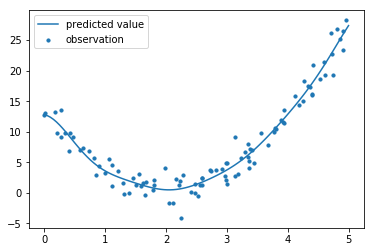

In [5]:
s=1
mu=[i/2 for i in range(10)]
M=len(mu)
lbmodel=LinearBasisFunctionModel(M,s,mu)
X_test=np.linspace(0,5,100)
lbmodel.fit(X,t)
t_test=lbmodel.predict(X_test)
plt.scatter(X,t,label='observation',s=10)
plt.plot(X_test,t_test,label='predicted value');
plt.legend()
#plt.plot(X_test,3*(X_test-2)**2+1);

## Bayesian Linear Regression Model

In [6]:
class BayesianLinearRegressionModel:
    def __init__(self,M,s,mu,alpha,beta):
        self.M=M   #number of basis functions
        self.s=s   #standard deviation of basis functions
        self.mu=mu #average of basis functions
        self.alpha=alpha
        self.beta=beta
    def gauss(self,x,mu):
        return np.exp(-((x-mu)**2)/(2*self.s**2))
    def design_matrix(self,X):
        gauss_function=np.zeros((len(X),self.M))
        for j in range(self.M):
            for i in range(len(X)):
                gauss_function[i,j]=self.gauss(X[i],self.mu[j])
        return gauss_function
    def posterior(self,X,t):
        Phi=self.design_matrix(X)
        self.SN=self.alpha*np.eye(Phi.shape[1])+self.beta*np.matmul(Phi.T,Phi)
        self.SN=np.linalg.inv(self.SN)
        self.mN=np.matmul(self.beta*self.SN,Phi.T)
        self.mN=np.dot(self.mN,t)
        return self
    def predict(self,X):
        Phi=self.design_matrix(X)
        average=np.matmul(self.mN.T,Phi.T)
        std=1/self.beta+np.matmul(np.matmul(Phi,self.SN),Phi.T)
        return average,np.diag(std)

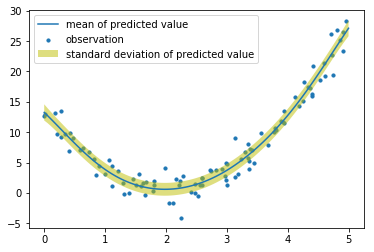

In [7]:
s=1
mu=[i/2-4 for i in range(30)]
M=len(mu)
alpha=0.01 
beta=1
blrmodel= BayesianLinearRegressionModel(M,s,mu,alpha,beta)
X_test=np.linspace(0,5,100)
blrmodel.posterior(X,t)
t_test,t_test_std=blrmodel.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(X,t,label='observation',s=10)
ax.plot(X_test,t_test,label='mean of predicted value');
ax.fill_between(X_test,t_test+t_test_std,t_test-t_test_std,facecolor='y',alpha=0.5,label='standard deviation of predicted value');
plt.legend();

## Bayesian Linear Regression Model using Evidence Approximation

In [8]:
from scipy.linalg import eigh
class BayesianLinearRegressionModel_EvidenceApproximation:
    def __init__(self,M,s,mu,max_iter=100,err=0.0001):
        self.M=M   #number of basis functions
        self.s=s   #standard deviation of basis functions
        self.mu=mu #average of basis functions
        self.alpha=10 #initial value
        self.beta=10  #intial value
        self.max_iter=max_iter
        self.err=err
    def gauss(self,x,mu):
        return np.exp(-((x-mu)**2)/(2*self.s**2))
    def design_matrix(self,X):
        gauss_function=np.zeros((len(X),self.M))
        for j in range(self.M):
            for i in range(len(X)):
                gauss_function[i,j]=self.gauss(X[i],self.mu[j])
        return gauss_function
    def evidence_approximation(self,X,t):
        Phi=self.design_matrix(X)
        eigen_value_original =eigh((Phi.T)@Phi)[0]
        eigen_value_original=np.array(eigen_value_original)
        for i in range(self.max_iter):
            alpha_tmp=self.alpha
            beta_tmp=self.beta
            self.posterior(X,t,Phi)
            eigen_value=self.beta*eigen_value_original
            gamma=np.sum(eigen_value/(self.alpha+eigen_value))
            self.alpha=gamma/(self.mN.T@self.mN)
            self.beta=(len(X)-gamma)/np.linalg.norm(t-Phi@self.mN,ord=2)
            if (abs((self.beta-beta_tmp)/self.beta)<self.err and abs((self.alpha-alpha_tmp)/self.alpha)<self.err) :
                print(i)
                break
            self.posterior(X,t,Phi)
        return self
    def posterior(self,X,t,Phi):
        self.SN=self.alpha*np.eye(Phi.shape[1])+self.beta*np.matmul(Phi.T,Phi)
        self.SN=np.linalg.inv(self.SN)
        self.mN=np.matmul(self.beta*self.SN,Phi.T)
        self.mN=np.dot(self.mN,t)
        return self
    def predict(self,X):
        Phi=self.design_matrix(X)
        average=np.matmul(self.mN.T,Phi.T)
        std=1/self.beta+np.matmul(np.matmul(Phi,self.SN),Phi.T)
        return average,np.diag(std)

7


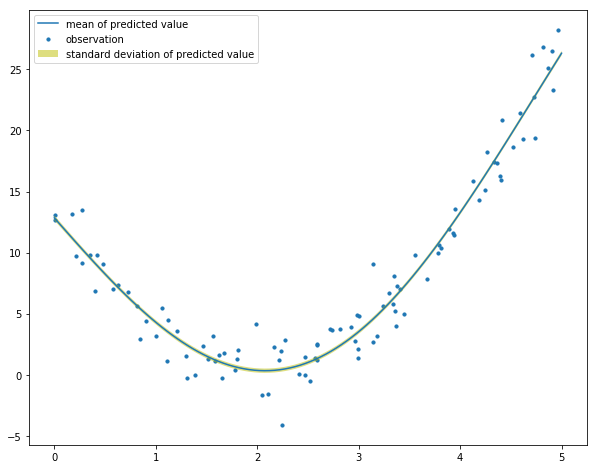

In [9]:
s=4
mu=[i/2 for i in range(4)]
M=len(mu)
blrmodel_ea= BayesianLinearRegressionModel_EvidenceApproximation(M,s,mu)
X_test=np.linspace(0,5,100)
blrmodel_ea.evidence_approximation(X,t)
t_test,t_test_std=blrmodel_ea.predict(X_test)
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X,t,label='observation',s=10)
ax.plot(X_test,t_test,label='mean of predicted value');
ax.fill_between(X_test,t_test+t_test_std,t_test-t_test_std,facecolor='y',alpha=0.5,label='standard deviation of predicted value');
plt.legend();